In [2]:
import pandas as pd
from collections import defaultdict
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import numpy as np
from sklearn.manifold import TSNE

In [3]:
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import cufflinks as cf
cf.go_offline()

Now that we've pre-processed our text, let's look at both the 'Sincere' and 'Insincere' classes.

In [21]:
train = pd.read_csv('../data/train_preprocessed.csv')

In [22]:
train.isnull().sum()

qid                      0
question_text            0
target                   0
clean_question_text    343
dtype: int64

In [23]:
train.dropna(inplace=True)

# Wordclouds

In [24]:
def cloud_maker(text, title, size = (10,7)):
    # Processing Text
    wordcloud = WordCloud(width=800, height=400,
                          collocations=False
                         ).generate(" ".join(text))
    
    # Output Visualization
    fig = plt.figure(figsize=size, dpi=80, facecolor='k',edgecolor='k')
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=25,color='w')
    plt.tight_layout(pad=0)
    plt.show()

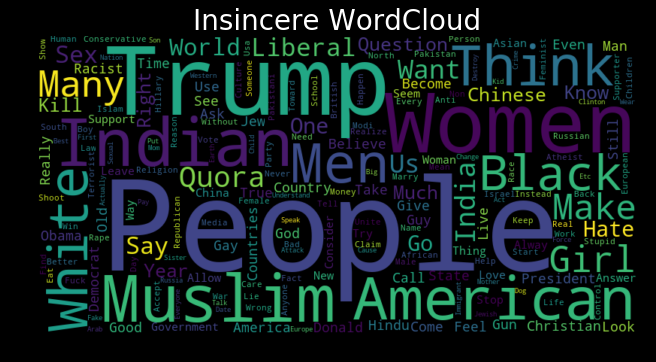

In [25]:
for name in train.loc[train.target == 1]:
    if type(name) == float:
        pass
cloud_maker(train.loc[train.target == 1,"clean_question_text"].str.title(), title="Insincere WordCloud".format(name), size=[8,5])


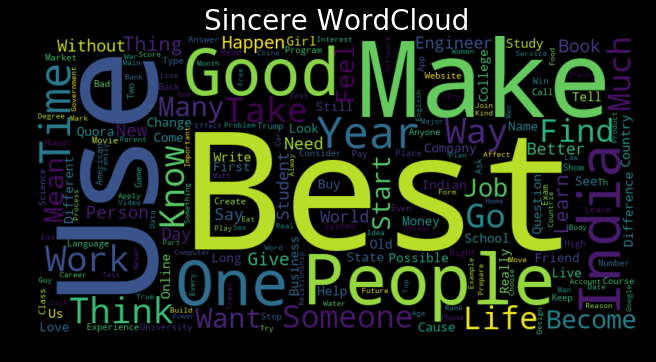

In [26]:
for name in train.loc[train.target == 0]:
    if type(name) == float:
        pass
cloud_maker(train.loc[train.target == 0,"clean_question_text"].str.title(), title="Sincere WordCloud".format(name), size=[8,5])

These word clouds do provide a decent snapshot of the most common words for each class. Similar to the Quora description of insincere content, these words do seem to indicate a tendency to focus on specific groups of people.

The sincere word cloud features words like "Best", "Good" or "Use", words that seem more in line with genuine questions.

It is interesting to note that "India" and "People" are among the most common words for both classes.

# N-Gram Analysis

In [4]:
def ngram_extractor(text, n_gram):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

In [2]:
# Function to generate a dataframe with n_gram and top max_row frequencies
def generate_ngrams(df, col, n_gram, max_row):
    temp_dict = defaultdict(int)
    for question in df[col]:
        for word in ngram_extractor(question, n_gram):
            temp_dict[word] += 1
    temp_df = pd.DataFrame(sorted(temp_dict.items(), key=lambda x: x[1])[::-1]).head(max_row)
    temp_df.columns = ["word", "wordcount"]
    return temp_df

In [3]:
def comparison_plot(df_1,df_2,col_1,col_2, space):
    fig, ax = plt.subplots(1, 2, figsize=(20,10))
    
    sns.barplot(x=col_2, y=col_1, data=df_1, ax=ax[0], color="palegreen")
    sns.barplot(x=col_2, y=col_1, data=df_2, ax=ax[1], color="lightcoral")

    ax[0].set_xlabel('Word count', size=14, color="black")
    ax[0].set_ylabel('Words', size=14, color="black")
    ax[0].set_title('Top words in sincere questions', size=18, color="black")

    ax[1].set_xlabel('Word count', size=14, color="black")
    ax[1].set_ylabel('Words', size=14, color="black")
    ax[1].set_title('Top words in insincere questions', size=18, color="black")

    fig.subplots_adjust(wspace=space)
    
    plt.show()

In [34]:
sincere_1gram = generate_ngrams(train[train["target"]==0], 'clean_question_text', 1, 20)

In [35]:
insincere_1gram = generate_ngrams(train[train["target"]==1], 'clean_question_text', 1, 20)

# Top Words

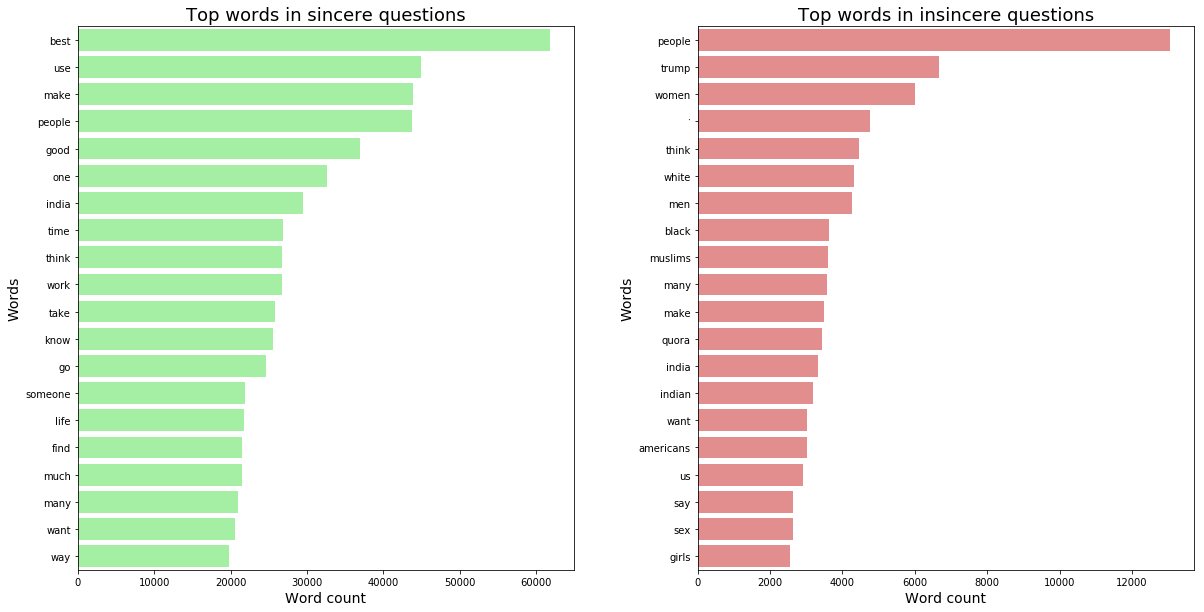

In [36]:
comparison_plot(sincere_1gram,insincere_1gram,'word','wordcount', 0.25)

Interestingly enough, "India" is located in the most popular word lists for both classes. Considering it has such a high population, this isn't terribly surprising, but perhaps it will give the model trouble.

The Kaggle problem statement mentioned that a lot of insincere posts were discriminatory in nature, so the fact that "women", "black", "white" and "muslim" are in the list of top insincere words. And since a lot of the "insincere" posts are also sexual in nature, it's not suprising to see "sex" on the top word list for insincere as well. Given how much discussion of Donald Trump there is on the internet (and to his antagonistic/troll-ish persona that many of his supporters also attempt to adopt) its also not surpising to see his name on there.

Although "people" is listed in both, it is overwhelmingly the most popular word in the "insincere" class. Given that a common cliche of a casually (or not so casually) predjudiced person is to use the term "you people", this is also an interesting finding. Equally for "us", since predjudiced people often have an "us vs. them" mentality toward the world.

It also makes sense that "best" is listed as the top word in the Sincere class, since presumably users would be interested in what the "best" of something is. It seems like most of the other top words in "sincere" are also pretty general words.

## Top bi-grams

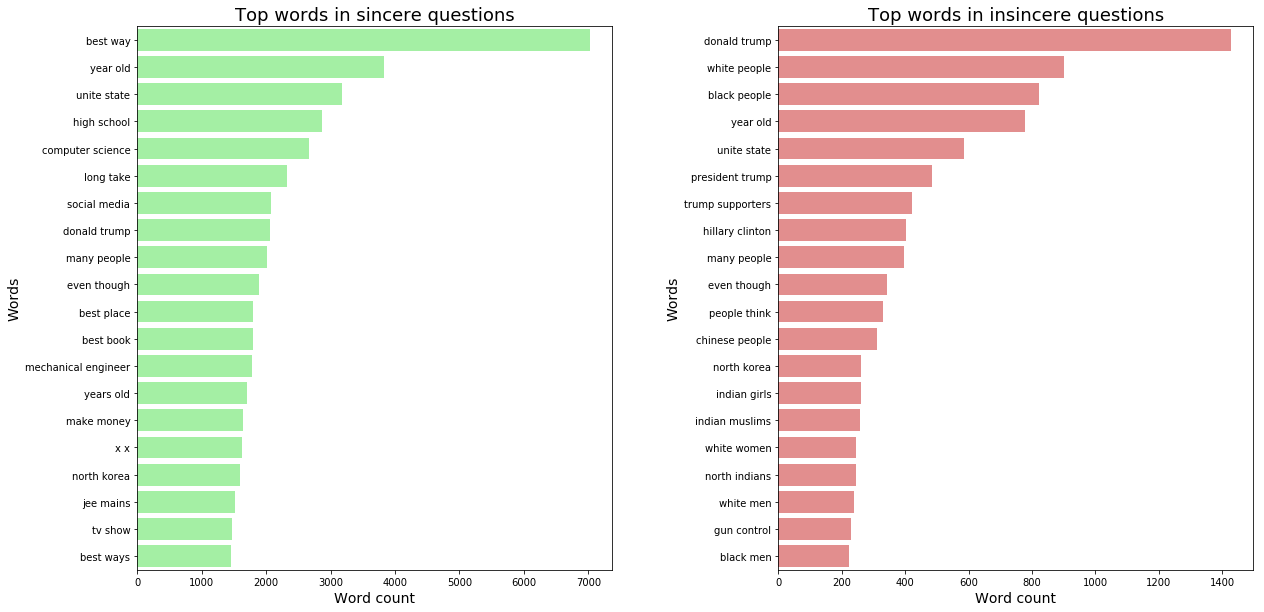

In [38]:
sincere_2gram = generate_ngrams(train[train["target"]==0], 'clean_question_text', 2, 20)
insincere_2gram = generate_ngrams(train[train["target"]==1], 'clean_question_text', 2, 20)
comparison_plot(sincere_2gram,insincere_2gram,'word','wordcount', .35)

The top bi-gram list arguably is more interesting than the list of single words.

Clearly there is some "signal" in the insincere words, as most of these bi-grams resonate as being more predjucial in nature. There are a lot of words that follow the pattern of "[adjective] + [type of person]"

Interestingly, "Donald Trump" and "North Korea" show up as the top bi-grams for both, likely because they represent hot button issues that people of all political persuasions.

## Top Tri-Grams

In [13]:
sincere_3gram = generate_ngrams(train[train["target"]==0], 'clean_question_text', 3, 20)
insincere_3gram = generate_ngrams(train[train["target"]==1], 'clean_question_text', 3, 20)

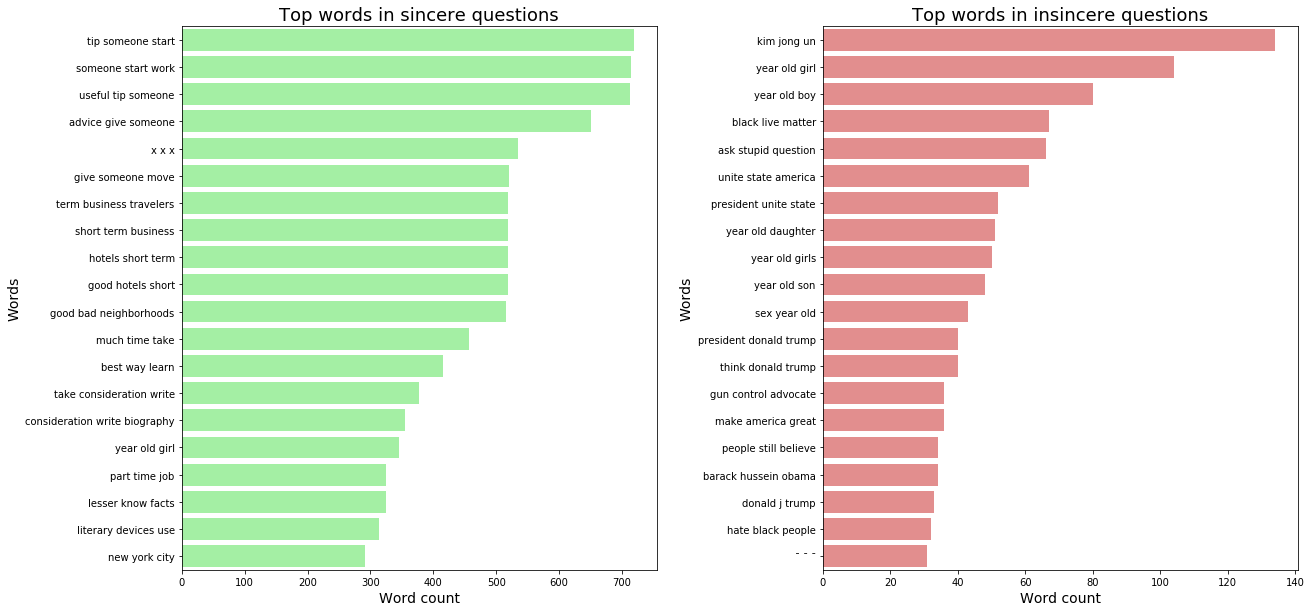

In [14]:
comparison_plot(sincere_3gram,insincere_3gram,'word','wordcount', .35)

Again, a lot of polarizing topics on display within the insincere class, and a lot of genuine seeming questions in the sincere class.

# Quad-Grams

In [15]:
sincere_4gram = generate_ngrams(train[train["target"]==0], 'clean_question_text', 4, 20)
insincere_4gram = generate_ngrams(train[train["target"]==1], 'clean_question_text', 4, 20)

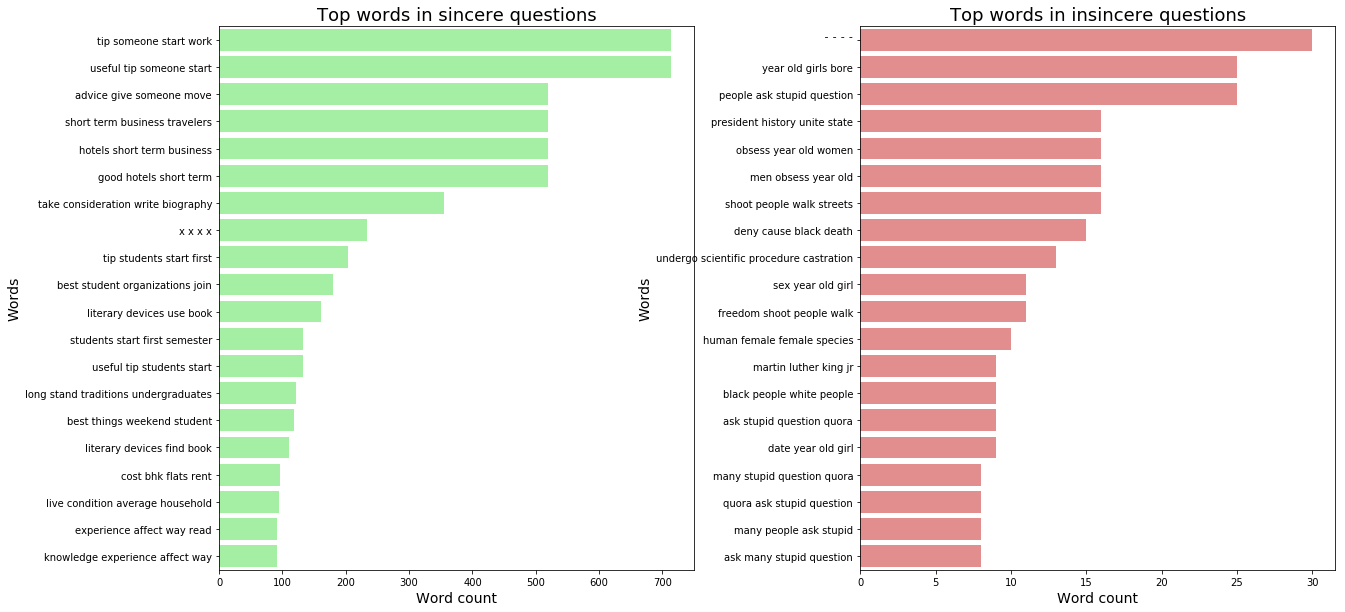

In [16]:
comparison_plot(sincere_4gram,insincere_4gram,'word','wordcount', .35)

In [21]:
train[train['clean_question_text'].str.contains("stupid")]['target'].value_counts(normalize=True)

1    0.509804
0    0.490196
Name: target, dtype: float64

# Visualize Words With T-SNE

In order to get a bit more perspective on the top words (and types of words) for each class, I am going to combine two techniques:

- Word embeddings
- T-SNE (t-distributed stochastic neighbor embedding)

Word embeddings are gigantic corpuses (such as the entirety of wikipedia) which have been "embedded" using algorithms that provide more contextual meaning around a word than counts or TFIDF. 

T-SNE is a dimensionality reduction technique that allows for high dimensional datasets to be plotted in 2 or 3 dimensions. When T-SNE is used on word embeddings, words with similar meaning tend to be grouped together in a very interesting way.

I will now plot the top sincere and insincere words according to their embeddings, with words used more in insincere class colored in red, while words used more in the sincere class are colored in green.

In case this does not render well in Github, this visualization is also available in the repo's image folder, as an .html file that can be opened locally, called 'TSNE-word-example.html'

In [27]:
ctv = CountVectorizer(analyzer='word',token_pattern=r"\w{1,}'?[t]?", ngram_range=(1, 2), stop_words = 'english')

In [30]:
tsnetrain = train[['target','clean_question_text']]

In [31]:
tsnetrain.columns = ['target','text']

In [33]:
ctv.fit(tsnetrain['text'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern="\\w{1,}'?[t]?", tokenizer=None,
        vocabulary=None)

In [34]:
train_pos = ctv.transform(tsnetrain[tsnetrain['target']==1]['text'])
train_neg = ctv.transform(tsnetrain[tsnetrain['target']==0]['text'])

In [35]:
#calculate which word is used more frequently in which class

train_pos = train_pos.sum(axis=0) / train_pos.sum()
train_neg = train_neg.sum(axis=0) / train_neg.sum()

train_diff = train_pos - train_neg

train_diff = train_diff.tolist()[0]

In [36]:
inv_voc = {v:k for k,v in ctv.vocabulary_.items()}
tup_list = [(value, inv_voc[ind]) for (ind, value) in enumerate(train_diff)]

In [37]:
most_sincere_words = sorted(tup_list)
most_insincere_words = sorted(tup_list, reverse=True)

In [40]:
%time
# load in the "Glove" embedding, which is also available at the Kaggle competition website
EMBEDDING_FILE = '../embeddings/glove.840B.300d.txt'
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 11.2 µs


In [43]:
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

In [44]:
[pos_scores, pos_words] = zip(*most_insincere_words)
[neg_scores, neg_words] = zip(*most_sincere_words)

In [45]:
top_sincere_words = most_sincere_words[:1000]
top_insincere_words = most_insincere_words[:1000]

In [46]:
words_to_keep = top_sincere_words + top_insincere_words
emb = np.array([list(embeddings_index[word[1]]) + [abs(word[0])/word[0], word[1]] for word in words_to_keep if word[1] in embeddings_index ])

In [49]:
%time
X = emb
X_embedded = TSNE(n_components=2).fit_transform(X[:,:300])

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 9.06 µs


In [52]:
%time
# Create a trace
trace = go.Scatter(
    x = X_embedded[:,0],
    y = X_embedded[:,1],
    mode = 'markers',
    marker=dict(
        color= ['rgb(51, 206, 111)' if val=='-1.0' else 'rgb(244, 86, 66)'  for val in list(X[:,300])]
    ),
    text = X[:,301]
)

data = [trace]
layout = go.Layout(title='Top Words according to their embeddings (projected on 2D by T-SNE)')
fig = go.Figure(data=data, layout=layout)
# Plot and embed in ipython notebook!
py.iplot(fig, filename='basic-scatter')

# or plot with: plot_url = py.plot(data, filename='basic-line')

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 21.9 µs


You can see some interesting groupings now that the words have been plotted according to their embeddings. There appear to be two quadrants that are heavily "insincere" words, and two quadrants with mostly "sincere words." Toward the middle of the plot, there is a mixture of both; perhaps those words are more neutral in nature?